In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
L = 1
K = 200
C = 1000
rho = 3000
l = K/(C*rho)
N_t = 10000
delta_x = 0.01
x = np.linspace(-L/2, L/2, int(L/delta_x))
x = np.pad(x, (1, 1), 'constant', constant_values=0)
T_0 = [np.sin(np.pi*x_i/L) for x_i in x]

In [30]:
tau = (delta_x**2)/(2*l)
tau

0.75

# Problem a)

In [3]:
def FTCS_rod(delta_t = 0.1):
    a = l*delta_t/delta_x**2
    T = [T_0]
    for t in range(N_t):
        T_new = np.zeros(int(L/delta_x)+2)
        T_old = T[-1]
        for i in range(1, T_new.shape[0]-1):
            T_new[i] = (1-2*a)*T_old[i]+a*(T_old[i-1]+T_old[i+1])
        T.append(T_new)
    return T

T = FTCS_rod()

In [4]:
import matplotlib; matplotlib.use("TkAgg")
import matplotlib.animation as animation

fig, ax = plt.subplots()

line, = ax.plot(x, T_0)
legend = plt.legend()

def animate(i):
    line.set_ydata(T[i])
    legend.set_title("Time step: {}".format(i))
    return line, legend

# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig=fig, func=animate, frames=N_t, init_func=init, interval=25, blit=True)

plt.xlabel("x")
plt.ylabel("T")
plt.title("Temperature development in the rod")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


# Problem b)

In [16]:
def T_exact(t):
    list_T_exact = np.zeros(len(x))
    f2 = np.exp(-(K*t*np.pi**2)/(C*rho*L**2))
    for i, x_i in enumerate(x):
        f1 = np.sin(np.pi*x_i/L)
        list_T_exact[i] = f1*f2
    list_T_exact = np.array(list_T_exact)
    return list_T_exact

def error(T, t):
    return (delta_x/L)*np.sum(np.abs(T[t]-T_exact(t)))

In [17]:
list_delta_t = np.linspace(0.001,0.7, 100)
def errors_for_delta_t(scheme):
    list_errors = []
    for dt in tqdm(list_delta_t):
        T_dt = scheme(dt)
        err = error(T_dt, 100)
        list_errors.append(err)
    return list_errors

list_errors_FTCS = errors_for_delta_t(FTCS_rod)

100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


Text(0.5, 0, '$\\Delta t$')

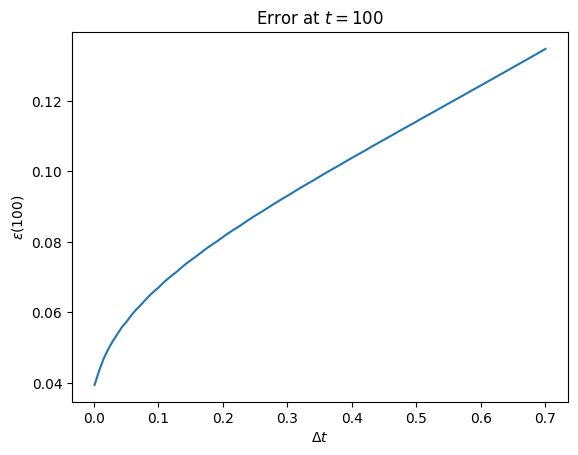

In [18]:
%matplotlib inline
plt.plot(list_delta_t, list_errors_FTCS)
plt.title("Error at $t=100$")
plt.ylabel("$\epsilon(100)$")
plt.xlabel("$\Delta t$")

The error gets larger with increasing $\Delta_t$. This is because the simulation approximates the exact solution with discrete steps in time. The time-dependent exponential factor in $T_{exact}$ is linearized between the discrete time steps. When $\Delta_{t}$ is increased, thus is the error made by linearization.

# Problem c)

In [35]:
def Euler_backward_rod(delta_t = 0.1):
    a = l*delta_t/delta_x**2
    T = [T_0]
    dim = len(x)
    A = np.eye(dim)
    for i in range(A.shape[0]-1):
        A[i+1, i] = -a
        A[i, i+1] = -a
    A[0, 1] = 0
    A[dim-1][dim-2] = 0
    for i in range(1, A.shape[0]-1):
        A[i,i] += 2*a
    A_inv = np.linalg.inv(A)
    for t in range(N_t):
        T_old = T[-1]
        T_new = np.matmul(A_inv, T_old)
        T.append(T_new)
    return T

T_euler_backward = Euler_backward_rod()

In [20]:
def Crank_Nicolson_rod(delta_t = 0.1):
    a = l*delta_t/delta_x**2
    T = [T_0]
    dim = len(x)
    A = np.eye(dim)
    B = np.eye(dim)
    for i in range(1, dim-1):
        A[i,i] += 2*a
        B[i,i] -= 2*a
        A[i, i-1] = -a
        A[i, i+1] = -a
        B[i, i-1] = a
        B[i, i+1] = a
    A_inv = np.linalg.inv(A)
    for t in range(N_t):
        T_old = T[-1]
        T_new_p = np.matmul(B, T_old)
        T_new = np.matmul(A_inv, T_new_p)
        T.append(T_new)
    return T

T_Crank_Nicolson = Crank_Nicolson_rod()

In [21]:
def DuFort_Frankel_rod(delta_t = 0.1):
    a = l*delta_t/delta_x**2
    T = [T_0]
    c = (1-a)/(1+a)
    d = a/(1+a)
    for t in range(N_t):
        T_new = np.zeros(int(L/delta_x)+2)
        T_old = T[-1]
        T_before = T[-2] if t>1 else np.zeros(int(L/delta_x)+2)
        for i in range(1, T_new.shape[0]-1):
            T_new[i] = c*T_before[i] + d*(T_old[i-1]+T_old[i+1])
        T.append(T_new)
    return T

T_DuFort_Frankel = DuFort_Frankel_rod()

In [36]:
print("Euler backward:")
list_errors_Euler_backward = errors_for_delta_t(Euler_backward_rod)
print("Crank Nicolson:")
list_errors_Crank_nicolson = errors_for_delta_t(Crank_Nicolson_rod)
print("DuFort-Frankel:")
list_errors_DuFort_Frankel = errors_for_delta_t(DuFort_Frankel_rod)

Euler backward:


100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


Crank Nicolson:


100%|██████████| 100/100 [03:22<00:00,  2.02s/it]


DuFort-Frankel:


100%|██████████| 100/100 [00:34<00:00,  2.93it/s]


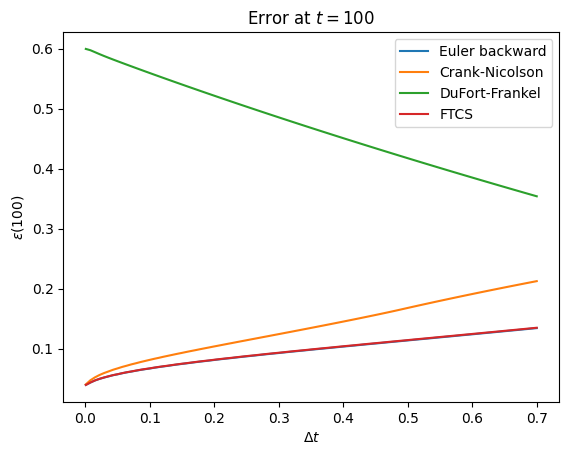

In [40]:
%matplotlib inline
plt.plot(list_delta_t, list_errors_Euler_backward, label="Euler backward")
plt.plot(list_delta_t, list_errors_Crank_nicolson, label="Crank-Nicolson")
plt.plot(list_delta_t, list_errors_DuFort_Frankel, label="DuFort-Frankel")
plt.plot(list_delta_t, list_errors_FTCS, label="FTCS")
plt.title("Error at $t=100$")
plt.ylabel("$\epsilon(100)$")
plt.xlabel("$\Delta t$")
plt.legend()

The errors for the Crank-Nicolson- and the DuFort-Frankel algorithm are in general higher than that of the Euler backward and FTCS. 